In [1]:
%matplotlib inline
import os
import tqdm
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import glob
import json 
import plotnine as pn
import matplotlib.pyplot as plt
import collections
from tcre.env import *
from tcre.supervision import get_candidate_classes, SPLIT_DEV, SPLIT_VAL, SPLIT_TEST, SPLIT_MAP
from tcre.exec.v1 import optim
from tcre.modeling import features
from snorkel.learning.utils import LabelBalancer
from snorkel import SnorkelSession
from snorkel.models import Candidate
import logging
session = SnorkelSession()
%run ../src/tcre/logging.py
classes = get_candidate_classes()

/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#output_dir = osp.join(RESULTS_DATA_DIR, 'gridsearch-dev', 'run1')
output_dir = osp.join(RESULTS_DATA_DIR, 'gridsearch-dev', 'run2')
output_dir

'/lab/data/results/gridsearch-dev/run2'

In [3]:
tasks = [classes[c].field for c in classes]
tasks

['inducing_cytokine', 'secreted_cytokine', 'inducing_transcription_factor']

### Initialize Optimizers

In [4]:
from skopt.space import Categorical
from skopt.space import Space

# space = Space([
#     Categorical(['doub_01'], name='marker_list'),
#     Categorical([True, False], name='use_secondary'),
#     Categorical([True, False], name='use_swaps'),
#     Categorical([True], name='use_positions'),
#     Categorical(['w2v_frozen', 'w2v_trained'], name='wrd_embedding_type'),
#     Categorical(['XL', 'XXL', 'XXXL', 'XXXXL'], name='model_size'),
#     Categorical([0.0, .00001, .0001, .001], name='weight_decay'),
#     Categorical([.005, .01, .05], name='learning_rate'),
#     Categorical([0.0, 0.25, 0.5, 0.75], name='dropout'),
#     Categorical(['LSTM'], name='cell_type'),
#     Categorical([False], name='bidirectional'),
#     Categorical([32, 512], name='batch_size'),
# ])

space = Space([
    Categorical(['doub_01'], name='marker_list'),
    Categorical([True, False], name='use_secondary'),
    Categorical([True], name='use_swaps'),
    Categorical([True], name='use_positions'),
    Categorical(['w2v_frozen', 'w2v_trained'], name='wrd_embedding_type'),
    Categorical(['XL', 'XXL', 'XXXL', 'XXXXL'], name='model_size'),
    Categorical([0.0, .0001, .001, .005], name='weight_decay'),
    Categorical([.005, .01, .05], name='learning_rate'),
    Categorical([0.0, 0.25, 0.5, 0.75], name='dropout'),
    Categorical(['LSTM'], name='cell_type'),
    Categorical([False], name='bidirectional')
])

In [5]:
n_space = np.prod([len(dim.categories) for dim in space])
print('Number of combinations in parameter space:', n_space)

Number of combinations in parameter space: 768


In [6]:
space.rvs()[0]

['doub_01',
 True,
 True,
 True,
 'w2v_trained',
 'XXXXL',
 0.001,
 0.05,
 0.25,
 'LSTM',
 False]

In [7]:
from skopt import forest_minimize, dummy_minimize

optimizers = {
    task: optim.TaskParameterOptimizer(
        task, space, output_dir, minimizer=dummy_minimize, client_args=dict(cli={'batch_size': 512})
    ) for task in tasks
}

In [8]:
optimizers[tasks[0]].client.exceptions

['log_level',
 'seed',
 'vocab_limit',
 'use_lower',
 'save_keys',
 'log_iter_interval',
 'log_epoch_interval',
 'balance',
 'batch_size',
 'simulation_strategy',
 'swap_list']

### Create Splits for Tasks

In [9]:
cands = session.query(Candidate).filter(Candidate.split.in_([SPLIT_DEV, SPLIT_VAL, SPLIT_TEST])).all()
len(cands)

2368

In [10]:
# Train on dev, use val for validation, and make test predictions
TARGET_MAP = {'dev': 'train', 'val': 'val', 'test': 'test'}
df_cand = pd.DataFrame([
    dict(id=c.id, task=c.type, split=TARGET_MAP[SPLIT_MAP[c.split]], label=features.get_label(c, strict=True))
    for c in cands
])
# Duplicate val candidates for prediction
df_cand = pd.concat([
    df_cand, df_cand[df_cand['split'] == 'val'].assign(split='predict')
])
df_cand.head()

,id,label,split,task
0,30167,1,train,inducing_cytokine
1,30168,0,train,inducing_cytokine
2,30169,1,train,inducing_cytokine
3,30170,1,train,inducing_cytokine
4,30171,0,train,inducing_cytokine


In [11]:
df_cand.groupby(['task', 'split']).size().unstack()

split,predict,test,train,val
task,,,,
inducing_cytokine,97,100,673,97
inducing_transcription_factor,117,100,410,117
secreted_cytokine,98,100,673,98


In [12]:
df_cand.groupby(['task', 'split'])['label'].value_counts().unstack().fillna(0).astype(int)

label                                    0    1
task                          split            
inducing_cytokine             predict   84   13
                              test      86   14
                              train    540  133
                              val       84   13
inducing_transcription_factor predict   95   22
                              test      82   18
                              train    324   86
                              val       95   22
secreted_cytokine             predict   79   19
                              test      80   20
                              train    592   81
                              val       79   19

In [13]:
max_train_samples = 2500
for task, g in df_cand.groupby('task'):
    _rs = lambda: np.random.RandomState(TCRE_SEED)
    
    def get_ids(df):
        split = df['split'].iloc[0]
        if split == 'predict':
            return df['id'].unique()
        df = df[(df['label'] - .5).abs() > 1e-6]
        idx = LabelBalancer(df['label'].values).get_train_idxs(rand_state=_rs(), rebalance=.5)
        df = df.iloc[idx]
        print(f'Label distribution for split {split}:', (df['label'] > .5).value_counts().to_dict())
        return df['id'].unique()
    splits = g.groupby('split').apply(get_ids)
    print(f'Splits for task "{task}":')
    print(splits.apply(len))
    splits_file = optimizers[task].write_splits(splits)
    print(f'Splits written to {splits_file}')

Label distribution for split test: {True: 14, False: 14}
Label distribution for split train: {True: 133, False: 133}
Label distribution for split val: {True: 13, False: 13}
Splits for task "inducing_cytokine":
split
predict     97
test        28
train      266
val         26
dtype: int64
Splits written to /lab/data/results/gridsearch-dev/run2/inducing_cytokine/splits/splits.json
Label distribution for split test: {True: 18, False: 18}
Label distribution for split train: {True: 86, False: 86}
Label distribution for split val: {True: 22, False: 22}
Splits for task "inducing_transcription_factor":
split
predict    117
test        36
train      172
val         44
dtype: int64
Splits written to /lab/data/results/gridsearch-dev/run2/inducing_transcription_factor/splits/splits.json
Label distribution for split test: {True: 20, False: 20}
Label distribution for split train: {True: 81, False: 81}
Label distribution for split val: {True: 19, False: 19}
Splits for task "secreted_cytokine":
split


### Run Search

In [14]:
# Show an example command to be run 
print(optimizers[tasks[0]].get_cmd(space.rvs()[0]))

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=inducing_cytokine --device="cuda:1" --output-dir=/lab/data/results/gridsearch-dev/run2/inducing_cytokine/data --batch-size=512 train --splits-file=/lab/data/results/gridsearch-dev/run2/inducing_cytokine/splits/splits.json --use-checkpoints=False --save-keys="history" --marker-list=doub_01 --use-secondary=True --use-swaps=True --use-positions=True --wrd-embedding-type=w2v_frozen --model-size=XXXL --weight-decay=0.0 --learning-rate=0.01 --dropout=0.25 --cell-type=LSTM --bidirectional=False > /lab/data/results/gridsearch-dev/run2/inducing_cytokine/log/log.txt 2>&1


In [15]:
# For 3 tasks at about about 30s per iteration, show common time estimations:
time_per_iter_sec = 30
n_iter = np.array([10, 100, 250, 500, 1000])
for n in n_iter:
    time = n * time_per_iter_sec * len(tasks) / 3600
    print(f'Iterations = {n} --> Time = {time} (hrs)')

Iterations = 10 --> Time = 0.25 (hrs)
Iterations = 100 --> Time = 2.5 (hrs)
Iterations = 250 --> Time = 6.25 (hrs)
Iterations = 500 --> Time = 12.5 (hrs)
Iterations = 1000 --> Time = 25.0 (hrs)


In [ ]:
results = {}

for task in tasks:
    optimizer = optimizers[task]
    logging.info(f'Running optimization for task {task}')
    # kappa=3.090 -> 99.8% confidence interval (favors exploration when higher than default 1.96)
    #res, scores, callbacks = optimizer.run(n_iterations=250, progress_interval=1, checkpoint_interval=10, n_random_starts=10, acq_func='LCB', kappa=3.090)
    res, scores, callbacks = optimizer.run(n_iterations=64, progress_interval=1, checkpoint_interval=10)
    
    # Save scores for non-objective (i.e. validation) after converting to long form
    scores = pd.DataFrame(scores)
    scores.columns = pd.MultiIndex.from_tuples([c for c in scores])
    scores = scores.rename_axis('iteration', axis=0).rename_axis(('metric', 'type'), axis=1)
    scores = scores.stack().stack().rename('value').reset_index()
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    scores.to_feather(scores_file)
    logging.info(f'Saved scores to {scores_file}')
    
    # Checkpoint final result since it is not saved at every step
    callbacks['saver'].i = -1
    callbacks['saver'](res)
    logging.info(f'Saved final result')
    
    results[task] = res, scores, callbacks

2019-07-10 21:14:23,822:INFO:root: Running optimization for task inducing_cytokine
2019-07-10 21:14:23,824:INFO:tcre.exec.v1.optim: Beginning parameter search with max iterations 64
2019-07-10 21:14:40,063:INFO:tcre.exec.v1.optim: Completed iteration 1 of 64 (score = -0.8)
2019-07-10 21:14:58,101:INFO:tcre.exec.v1.optim: Completed iteration 2 of 64 (score = -0.7741935483870961)
2019-07-10 21:15:16,247:INFO:tcre.exec.v1.optim: Completed iteration 3 of 64 (score = -0.8125000000000001)
2019-07-10 21:15:34,293:INFO:tcre.exec.v1.optim: Completed iteration 4 of 64 (score = -0.6666666666666661)
2019-07-10 21:15:53,113:INFO:tcre.exec.v1.optim: Completed iteration 5 of 64 (score = -0.785714285714285)
2019-07-10 21:16:10,475:INFO:tcre.exec.v1.optim: Completed iteration 6 of 64 (score = -0.7272727272727271)
2019-07-10 21:16:28,959:INFO:tcre.exec.v1.optim: Completed iteration 7 of 64 (score = -0.8571428571428571)
2019-07-10 21:16:47,346:INFO:tcre.exec.v1.optim: Completed iteration 8 of 64 (score =

In [ ]:
print(tasks[0])
res, scores, callbacks = results[tasks[0]]

In [ ]:
times = callbacks['timer'].iter_time
pd.Series(times).describe()

In [25]:
res.func_vals[:5]

array([-0.36363636, -0.44444444, -0.4       , -0.24      , -0.34482759])

In [26]:
pd.DataFrame(res.x_iters[:5], columns=[dim.name for dim in space])

,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional
0,doub_01,True,False,True,w2v_frozen,XXL,0.000,0.005,0.75,LSTM,False
1,doub_01,False,False,True,w2v_frozen,XXL,0.001,0.010,0.25,LSTM,False
2,doub_01,False,False,True,w2v_frozen,XXXL,0.001,0.005,0.00,LSTM,False
3,doub_01,False,False,True,w2v_frozen,L,0.001,0.001,0.75,LSTM,False
4,doub_01,True,True,True,w2v_frozen,XXXL,0.001,0.001,0.00,LSTM,False


In [27]:
res.models[:5]

[]

## Analysis

In [11]:
output_dir

'/lab/data/results/gridsearch-dev/run2'

In [12]:
!ls $output_dir

inducing_cytokine	       secreted_cytokine
inducing_transcription_factor  top_model_configurations.json


In [13]:
import skopt
# Restore from serialized data

results = {}
for task in tasks:
    optimizer = optimizers[task]
    res = skopt.load(optimizer.get_checkpoints_file())
    
    scores = None
    scores_file = osp.join(optimizer.output_dir, 'scores.feather')
    if osp.exists(scores_file):
        scores = pd.read_feather(scores_file)
    
    results[task] = res, scores, globals().get('times') 

In [14]:
def get_dfx(results):
    df = []
    for k in results:
        res = results[k][0]
        dfx = pd.DataFrame(res.x_iters, columns=[dim.name for dim in space])
        dfx['score'] = -res.func_vals
        dfx['task'] = k
        dfx['iteration'] = np.arange(len(dfx))
        df.append(dfx)
    return pd.concat(df)

In [15]:
dfx = get_dfx(results)
props = dfx.drop(['score', 'task', 'iteration'], axis=1).columns.tolist()
print(props)
dfx.head()

['marker_list', 'use_secondary', 'use_swaps', 'use_positions', 'wrd_embedding_type', 'model_size', 'weight_decay', 'learning_rate', 'dropout', 'cell_type', 'bidirectional']


,marker_list,use_secondary,use_swaps,use_positions,wrd_embedding_type,model_size,weight_decay,learning_rate,dropout,cell_type,bidirectional,score,task,iteration
0,doub_01,True,True,True,w2v_trained,XXXXL,0.0000,0.010,0.75,LSTM,False,0.444444,inducing_cytokine,0
1,doub_01,False,True,True,w2v_trained,XXXXL,0.0010,0.050,0.25,LSTM,False,0.368421,inducing_cytokine,1
2,doub_01,False,True,True,w2v_frozen,XXXXL,0.0010,0.010,0.00,LSTM,False,0.400000,inducing_cytokine,2
3,doub_01,False,True,True,w2v_trained,XXL,0.0010,0.005,0.75,LSTM,False,0.333333,inducing_cytokine,3
4,doub_01,True,True,True,w2v_trained,XXXXL,0.0001,0.005,0.00,LSTM,False,0.413793,inducing_cytokine,4


In [16]:
# Show top configs by task
pd.set_option('display.max_rows', 100)
dfx.groupby('task').apply(lambda g: g.sort_values('score', ascending=False).iloc[:8].reset_index(drop=True)).style.background_gradient()

### Parameter Regression

In [17]:
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='The default of the `iid` parameter.*')

def get_coefs(est):
    coefs = []
    grps = dfx.groupby(['task'])
    fig, axs = plt.subplots(1, len(grps))
    if len(grps) == 1:
        axs = [axs]
    fig.set_size_inches(18, 4)
    for i, (k, g) in enumerate(grps):
        X = pd.get_dummies(g.drop(['task', 'iteration', 'score'], axis=1).astype(str), prefix_sep=':')
        y = g['score'].values
        est = est.fit(X.values, y)
        y_pred = est.predict(X)
        score = max(r2_score(y, y_pred), 0)
        title = f'{est.__class__.__name__} {k} (R2={score:.2f})'
        pd.DataFrame({'y_true': y, 'y_pred': y_pred}).plot(kind='scatter', x='y_pred', y='y_true', ax=axs[i], title=title)
        coefs.append(
            pd.Series(est.coef_, index=X.columns.to_list()).sort_index()
            .append(pd.Series(dict(task=k, score=score, est=est.__class__.__name__)))
        )
    return est, pd.DataFrame(coefs)

def plot_coefs(est, coefs):
    return (
        pn.ggplot(
            coefs
                .set_index('task').rename_axis('metric', axis='columns').stack().rename('value').reset_index()
                .assign(metric=lambda df: pd.Categorical(df['metric'], ordered=True, categories=df.groupby('metric')['value'].mean().sort_values().index)), 
            pn.aes(x='metric', y='value', fill='task', color='task', group='task')
        ) + 
        pn.geom_point() +
        pn.geom_line() + 
        pn.ggtitle(type(est).__name__) + 
        pn.theme(figure_size=(12, 4), axis_text_x=pn.element_text(rotation=90, hjust=.5))
    )

In [18]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV

bidirectional:False  \
task                          score    est          weight                          
inducing_cytokine             0.265282 RidgeCV      0.317412                  0.0   
                              0.287502 LassoCV      0.343998                  0.0   
                              0.282983 ElasticNetCV 0.338591                  0.0   
inducing_transcription_factor 0.595924 RidgeCV      0.340991                  0.0   
                              0.576875 LassoCV      0.330091                  0.0   

                                                              cell_type:LSTM  \
task                          score    est          weight                     
inducing_cytokine             0.265282 RidgeCV      0.317412             0.0   
                              0.287502 LassoCV      0.343998             0.0   
                              0.282983 ElasticNetCV 0.338591             0.0   
inducing_transcription_factor 0.595924 RidgeCV      0.340991             0.0   
                              0.576875 LassoCV      0.330091             0.0   

                                                              dropout:0.0  \
task                          score    est          weight                  
inducing_cytokine             0.265282 RidgeCV      0.317412    -0.004712   
                              0.287502 LassoCV      0.343998    -0.000000   
                              0.282983 ElasticNetCV 0.338591    -0.000000   
inducing_transcription_factor 0.595924 RidgeCV      0.340991    -0.006727   
                              0.576875 LassoCV      0.330091    -0.000000   

                                                              dropout:0.25  \
task                          score    est          weight                   
inducing_cytokine             0.265282 RidgeCV      0.317412     -0.004633   
                              0.287502 LassoCV      0.343998     -0.000000   
                              0.282983 ElasticNetCV 0.338591     -0.000000   
inducing_transcription_factor 0.595924 RidgeCV      0.340991     -0.001655   
                              0.576875 LassoCV      0.330091      0.000000   

                                                              dropout:0.5  \
task                          score    est          weight                  
inducing_cytokine             0.265282 RidgeCV      0.317412     0.006982   
                              0.287502 LassoCV      0.343998     0.006706   
                              0.282983 ElasticNetCV 0.338591     0.006425   
inducing_transcription_factor 0.595924 RidgeCV      0.340991    -0.005095   
                              0.576875 LassoCV      0.330091    -0.000000   

                                                              dropout:0.75  \
task                          score    est          weight                   
inducing_cytokine             0.265282 RidgeCV      0.317412     -0.000504   
                              0.287502 LassoCV      0.343998      0.000000   
                              0.282983 ElasticNetCV 0.338591      0.000000   
inducing_transcription_factor 0.595924 RidgeCV      0.340991      0.013168   
                              0.576875 LassoCV      0.330091      0.011291   

                                                              learning_rate:0.005  \
task                          score    est          weight                          
inducing_cytokine             0.265282 RidgeCV      0.317412             0.014165   
                              0.287502 LassoCV      0.343998             0.028320   
                              0.282983 ElasticNetCV 0.338591             0.026951   
inducing_transcription_factor 0.595924 RidgeCV      0.340991             0.000236   
                              0.576875 LassoCV      0.330091             0.000000   

                                                              learning_rate:0.01  \
task                          score    est         

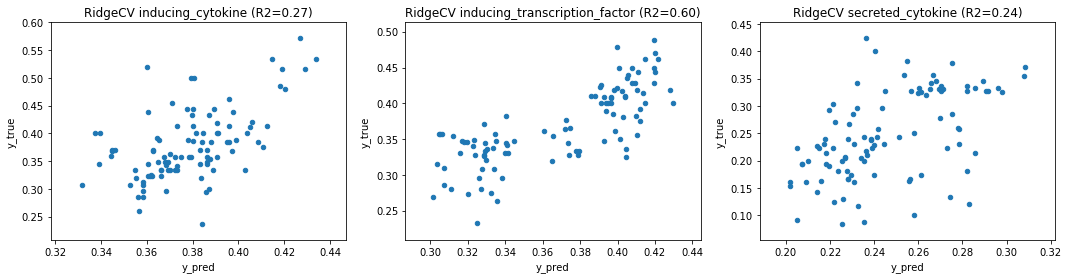

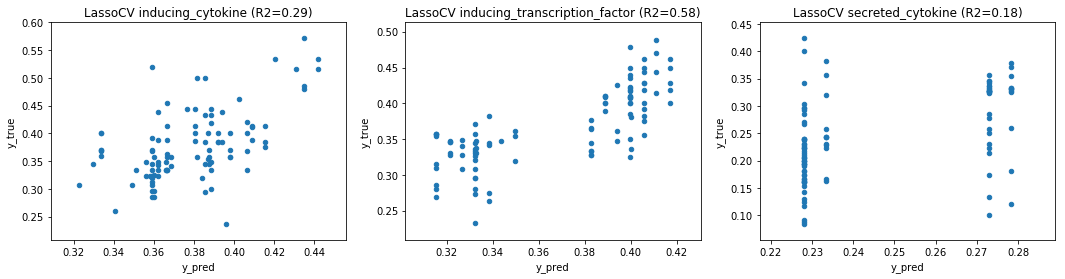

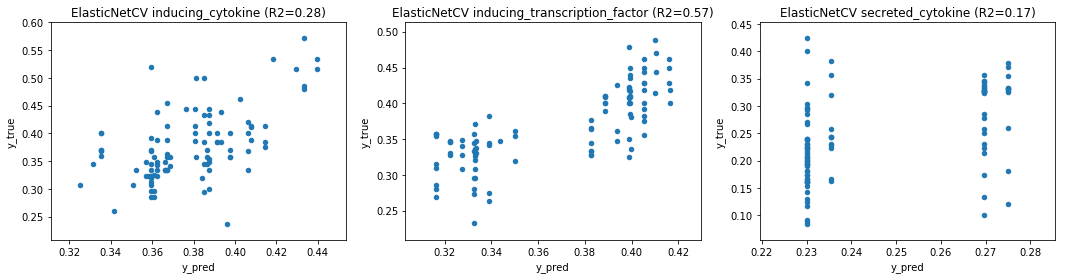

In [19]:
df_coef = pd.concat([
    get_coefs(RidgeCV(normalize=True, cv=5))[1],
    get_coefs(LassoCV(normalize=True, cv=5, random_state=1))[1],
    get_coefs(ElasticNetCV(normalize=True, cv=5, random_state=1))[1]
])

# Add weight for each model as R2 for model / R2 for all models
df_coef = df_coef.groupby('task', group_keys=False).apply(lambda g: g.assign(weight=(g['score'] / g['score'].sum())))
df_coef = df_coef.set_index(['task', 'score', 'est', 'weight'])

df_coef.head()

In [20]:
df_coef_lng = df_coef.rename_axis('parameter', axis='columns').stack().rename('value').reset_index()
df_coef_lng['weighted_value'] = df_coef_lng['value'] * df_coef_lng['weight']
df_coef_lng.head()

,task,score,est,weight,parameter,value,weighted_value
0,inducing_cytokine,0.265282,RidgeCV,0.317412,bidirectional:False,0.000000,0.000000
1,inducing_cytokine,0.265282,RidgeCV,0.317412,cell_type:LSTM,0.000000,0.000000
2,inducing_cytokine,0.265282,RidgeCV,0.317412,dropout:0.0,-0.004712,-0.001496
3,inducing_cytokine,0.265282,RidgeCV,0.317412,dropout:0.25,-0.004633,-0.001471
4,inducing_cytokine,0.265282,RidgeCV,0.317412,dropout:0.5,0.006982,0.002216


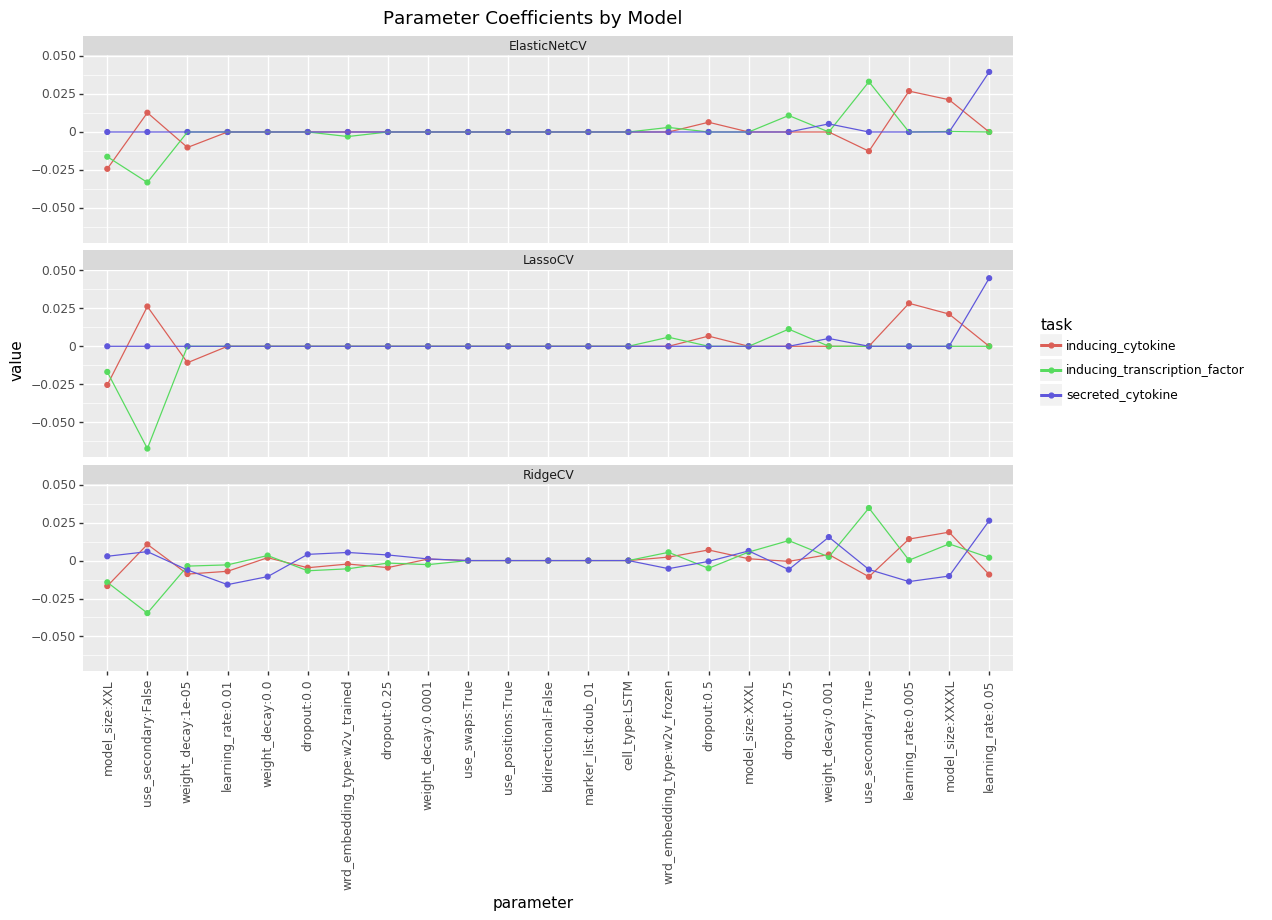

<ggplot: (8760407273946)>

In [21]:
(
    pn.ggplot(
        df_coef_lng.assign(parameter=lambda df: pd.Categorical(
            df['parameter'], ordered=True, 
            categories=df.groupby('parameter')['weighted_value'].mean().sort_values().index
        )), 
        pn.aes(x='parameter', y='value', fill='task', color='task', group='task')
    ) + 
    pn.geom_point() +
    pn.geom_line() + 
    pn.ggtitle('Parameter Coefficients by Model') + 
    pn.facet_wrap('~ est', ncol=1) +
    pn.theme(figure_size=(12, 8), axis_text_x=pn.element_text(rotation=90, hjust=.5))
)

### Score Distributions

In [22]:
df_score = pd.concat([v[1].assign(task=k) for k, v in results.items()])
df_score.head()

,iteration,type,metric,value,task
0,0,test,accuracy,0.760000,inducing_cytokine
1,0,test,ct,100.000000,inducing_cytokine
2,0,test,f1,0.076923,inducing_cytokine
3,0,test,loss,0.633976,inducing_cytokine
4,0,test,lr,0.010000,inducing_cytokine


In [23]:
# Label balance
df_lbl = df_cand.assign(label=lambda df: np.where(df['label'] > 0, 1, 0))
pd.concat([
    df_lbl.assign(agg='count').groupby(['task', 'split', 'agg'])['label'].value_counts().unstack([-2, -1]),
    df_lbl.assign(agg='percent').groupby(['task', 'split', 'agg'])['label'].value_counts(normalize=True).unstack([-2, -1]).round(2)
], axis=1)

agg                                   count      percent      
label                                     0    1       0     1
task                          split                           
inducing_cytokine             predict    84   13    0.87  0.13
                              test       86   14    0.86  0.14
                              train     540  133    0.80  0.20
                              val        84   13    0.87  0.13
inducing_transcription_factor predict    95   22    0.81  0.19
                              test       82   18    0.82  0.18
                              train     324   86    0.79  0.21
                              val        95   22    0.81  0.19
secreted_cytokine             predict    79   19    0.81  0.19
                              test       80   20    0.80  0.20
                              train     592   81    0.88  0.12
                              val        79   19    0.81  0.19

In [24]:
# Scores at best validation F1 iteration
df_bal = df_lbl.assign(metric='balance').groupby(['task', 'metric', 'split'])['label'].value_counts(normalize=True).unstack().round(2)[1].unstack([-2, -1])
(
    df_score
    .pivot_table(index=['task', 'iteration'], columns=['metric', 'type'], values='value')
    .pipe(lambda df: df.groupby('task').apply(lambda g: g.iloc[np.argmax(g[('f1', 'validation')].values)])[['ct', 'f1', 'accuracy', 'precision', 'recall']])
    .round(2)
    .pipe(lambda df: pd.concat([df, df_bal], axis=1))
    .style.background_gradient(low=.1, high=.3)
)

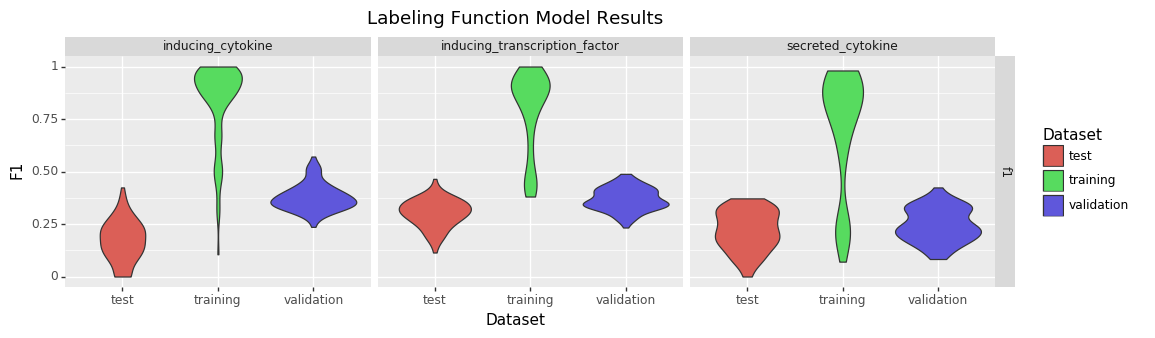

<ggplot: (8760406853296)>

In [27]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.labs(y='F1', title='Labeling Function Model Results', x='Dataset', fill='Dataset') + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 3))
)

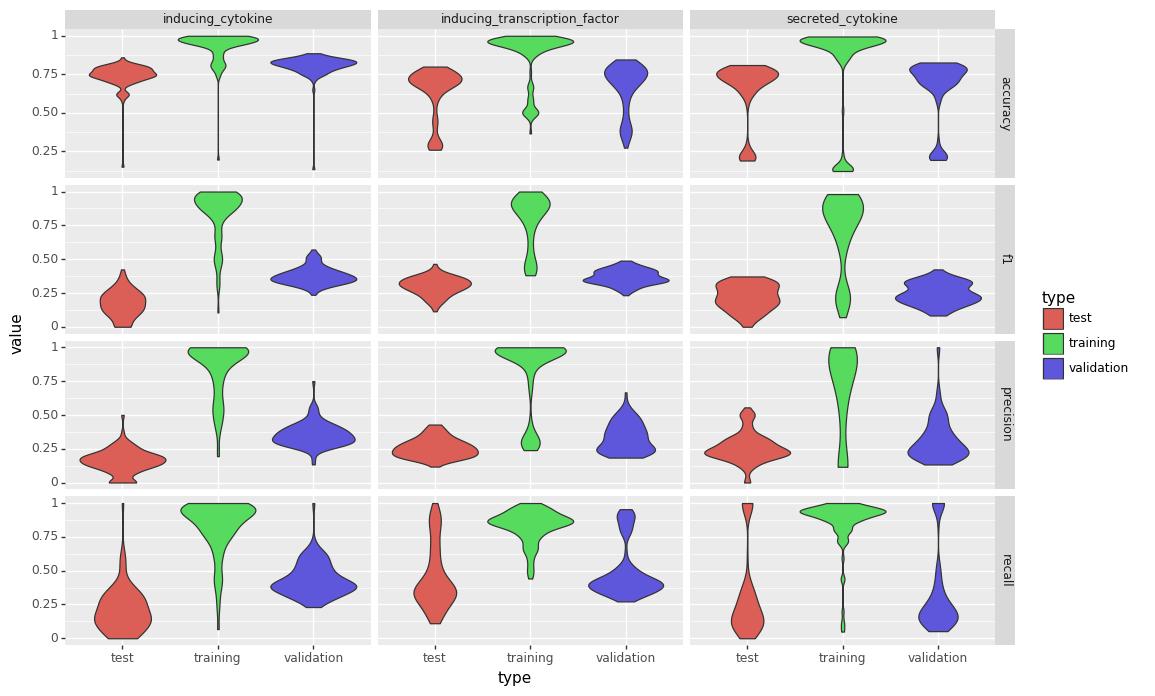

<ggplot: (8760406835362)>

In [25]:
(
    pn.ggplot(
        df_score.pipe(lambda df: df[df['metric'].isin(['f1', 'accuracy', 'precision', 'recall'])]),
        pn.aes(x='type', y='value', fill='type')
    ) + 
    pn.geom_violin() + 
    pn.facet_grid('metric ~ task', scales='free') + 
    pn.theme(figure_size=(12, 8))
)

## Export

Export top model configurations for each task.

In [220]:
# Show top 3 models
dftm = dfx.groupby('task', group_keys=False)\
    .apply(lambda g: g.sort_values('score', ascending=False).iloc[:3].reset_index(drop=True).assign(rank=lambda df: 1+np.arange(len(df))))\
    .reset_index(drop=True)\
    .rename(columns={dim.name: f'param:{dim.name}' for dim in space})
dftm

,param:marker_list,param:use_secondary,param:use_swaps,param:use_positions,param:wrd_embedding_type,param:model_size,param:weight_decay,param:learning_rate,param:dropout,param:cell_type,param:bidirectional,score,task,iteration,rank
0,doub_01,False,True,True,w2v_frozen,XXXXL,0.0000,0.005,0.75,LSTM,False,0.571429,inducing_cytokine,44,1
1,doub_01,False,True,True,w2v_trained,XXXL,0.0010,0.005,0.50,LSTM,False,0.533333,inducing_cytokine,29,2
2,doub_01,False,True,True,w2v_frozen,XXXXL,0.0001,0.005,0.50,LSTM,False,0.533333,inducing_cytokine,70,3
3,doub_01,True,True,True,w2v_trained,XXXL,0.0000,0.050,0.75,LSTM,False,0.488889,inducing_transcription_factor,68,1
4,doub_01,True,True,True,w2v_trained,XXXL,0.0000,0.010,0.25,LSTM,False,0.478261,inducing_transcription_factor,67,2
5,doub_01,True,True,True,w2v_trained,XXXXL,0.0000,0.010,0.75,LSTM,False,0.470588,inducing_transcription_factor,26,3
6,doub_01,False,True,True,w2v_trained,XXL,0.0000,0.010,0.25,LSTM,False,0.424242,secreted_cytokine,49,1
7,doub_01,False,True,True,w2v_trained,XXL,0.0001,0.005,0.75,LSTM,False,0.400000,secreted_cytokine,91,2
8,doub_01,False,True,True,w2v_trained,XXL,0.0010,0.005,0.75,LSTM,False,0.382979,secreted_cytokine,3,3


In [222]:
path = osp.join(output_dir, 'top_model_configurations.json')
dftm.to_json(path)
path

'/lab/data/results/gridsearch-dev/run2/top_model_configurations.json'

## Debug

In [144]:
debug_task = tasks[1]
optimizer = optimizers[debug_task]
debug_task

'secreted_cytokine'

In [154]:
model_config = dfx.groupby('task').apply(lambda g: g.sort_values('score', ascending=False).iloc[0]).loc[debug_task]
model_config

marker_list                     doub_01
use_secondary                     False
use_swaps                          True
use_positions                      True
wrd_embedding_type          w2v_trained
model_size                          XXL
weight_decay                          0
learning_rate                      0.01
dropout                            0.25
cell_type                          LSTM
bidirectional                     False
score                          0.424242
task                  secreted_cytokine
iteration                            49
Name: secreted_cytokine, dtype: object

In [155]:
#model_config['model_size'] = 'XL'

In [156]:
# Train on top config
train_args = dict(optimizer.train_args([model_config[dim.name] for dim in space]))
train_args['use_checkpoints'] = True
del train_args['save_keys']
args = dict(cli=optimizer.cli_args(), train=train_args)
cmd = optimizer.format(optimizer.client.cmd(**args))
print(cmd)
optimizer.client.execute(cmd)

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=secreted_cytokine --device="cuda:1" --output-dir=/lab/data/results/gridsearch-dev/run2/secreted_cytokine/data --batch-size=512 train --splits-file=/lab/data/results/gridsearch-dev/run2/secreted_cytokine/splits/splits.json --use-checkpoints=True --marker-list=doub_01 --use-secondary=False --use-swaps=True --use-positions=True --wrd-embedding-type=w2v_trained --model-size=XXL --weight-decay=0.0 --learning-rate=0.01 --dropout=0.25 --cell-type=LSTM --bidirectional=False > /lab/data/results/gridsearch-dev/run2/secreted_cytokine/log/log.txt 2>&1


0

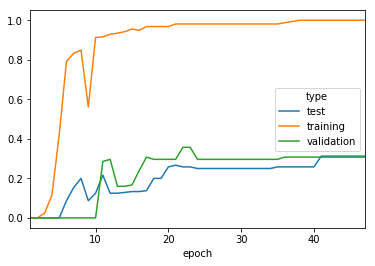

In [157]:
pd.read_json(osp.join(optimizer.output_dir, 'data', 'history.json'))\
    .set_index(['epoch', 'type'])['f1'].unstack().plot()

In [158]:
# Predict with trained model
predict_args = dict(splits_file=optimizer.get_splits_file())
args = dict(cli=optimizer.cli_args(), predict=predict_args)
cmd = optimizer.format(optimizer.client.cmd(**args))
print(cmd)
optimizer.client.execute(cmd)

python /lab/repos/t-cell-relation-extraction/src/tcre/exec/v1/cli.py --relation-class=secreted_cytokine --device="cuda:1" --output-dir=/lab/data/results/gridsearch-dev/run2/secreted_cytokine/data --batch-size=512 predict --splits-file=/lab/data/results/gridsearch-dev/run2/secreted_cytokine/splits/splits.json > /lab/data/results/gridsearch-dev/run2/secreted_cytokine/log/log.txt 2>&1


0

In [159]:
from tcre import visualization
import imp
imp.reload(visualization)

df_pred = pd.read_json(osp.join(optimizer.output_dir, 'data', 'predictions.json')).set_index('id')
pred_cands = session.query(Candidate).filter(Candidate.type == debug_task).all()
pred_cands = [c for c in pred_cands if c.id in df_pred.index]
assert len(pred_cands) == len(df_pred)
df_pred = pd.merge(df_pred.reset_index(), visualization.candidate_df(pred_cands), on='id', how='inner')
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 8 columns):
id        98 non-null int64
y_true    98 non-null int64
y_pred    98 non-null float64
type      98 non-null object
split     98 non-null int64
e1        98 non-null object
e2        98 non-null object
text      98 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 6.9+ KB


In [160]:
df_pred['y_true'].unique(), (df_pred['y_true'] > .5).value_counts()

(array([0, 1]), False    79
 True     19
 Name: y_true, dtype: int64)

In [161]:
(df_pred['y_pred'] > .5).value_counts()

False    89
True      9
Name: y_pred, dtype: int64

In [162]:
from IPython.display import HTML
pd.set_option('display.max_colwidth', 600)
#HTML(df_pred.sort_values('y_pred', ascending=False).head(25).to_html(escape=False))
HTML(df_pred[df_pred['y_true'] == 1].sort_values('y_pred', ascending=False).head(25).to_html(escape=False))
#HTML(df_pred[df_pred['y_pred'] > .5].sort_values('y_pred', ascending=False).head(25).to_html(escape=False))

,id,y_true,y_pred,type,split,e1,e2,text
60,291424,1,0.995636,secreted_cytokine,4,IFN-γ,γδT,We next sought to determine if the production of IFN-γ by CD161 + γδT cells in response to TCR - independent cytokine stimulation occurred in both the Vδ1 + and Vδ2 + γδT cell subsets .
73,364562,1,0.990747,secreted_cytokine,4,IL-23,Th17,"Th17 cells express the IL-23 receptor ( IL-23R ) , and the exquisite pathogenicity of Th17 cells may be associated with their capacity to respond to IL-23 (; ; ; ) . \n"
80,333888,1,0.981965,secreted_cytokine,4,IL-4,Th2,"For example , the cytokines typically produced by Th2 cells , including IL-4 , IL-5 and IL-13 , are silenced in Th1 cells through histone modification [ ] ."
55,288940,1,0.634935,secreted_cytokine,4,TNF-α,Th1,"Supporting this hypothesis , we also found that TNF-α , a cytokine , which can be produced by Th17 and Th1 cells , neither influenced the CD44 level of IL-17 + nor IFN-γ+CD4 + T cells ."
94,298139,1,0.527107,secreted_cytokine,4,IL-4,Th2,"Th2 cells express IL-4 , IL-5 , and IL-13 , which stimulates mucosal immunity against parasite infections ( – ) ."
90,327843,1,0.200419,secreted_cytokine,4,IL-21,Th17,"Another subset that has become increasingly important is Th17 cells that produce a variety of cytokines including IL-17A , IL-21 and IL-22 ."
10,58853,1,0.192096,secreted_cytokine,4,IFN-γ,NKT,"Based on the expression of an invariant TCRα chain ( Vα14-Jα18 in mice , Vα24-Jα18 in humans ) , CD1d - dependent NKT cells can be classified into type I and type II NKT cells , both of which can produce IFN-γ , the Th1 cytokine , and IL-4 , a Th2 cytokine , and participate in the regulation of innate and adaptive immunity ."
9,365585,1,0.147616,secreted_cytokine,4,IL-17,Th17,"The signaling cascade of IL-17 , the signature cytokine of Th17 cells , requires a key signaling molecule , Act1 ( also known as TRAF3IP2 or CIKS ) to propagate downstream signaling events in tissue cells , including activation of the transcription factor NF-κB. The absence of Act1 leads to resistance to IL-17-mediated inflammation in mouse models of experimental autoimmune encephalomyelitis ( EAE ) and asthma ."
61,347530,1,0.131577,secreted_cytokine,4,IL-13,Th2,"Dominance of Th2 responses ( – ) and Th2 cytokines IL-4 ( – ) , IL-10 ( ) , and IL-13 ( ) , can protect against autoimmunity , but their effects are variable . Th2"
66,323721,1,0.126618,secreted_cytokine,4,IL-10,TH17,"a Quantitative RT - PCR analysis of gene expression in human IL-10– and IL-10 + TH17 clones isolated from healthy donors ( two tailed , paired Student ’s t test , mean ± s.d ."
